# Prediction Challenge - using the extension of the data
This notebook contains our attempt to predict `CO2 Emissions per Capita (metric tonnes)` for each city but here we will apply the external data as well. The same model, the elastic net, as well as the same modeling architecture used in the notebook `3_modelling.ipynb` will be utilized in this notebook. These will not be described instead we refer to `3_modelling.ipynb` for comments on the choice of model and 'nuts and bolts of machine learning'. This notebook consist of two parts, namely

* Part 1: **Prediction Challenge 1**
> In this part the first prediction challenges will be considered. That is the training set will consist of the first 75 % row and the remaining 25% rows will act as the test set.
* Part 2: **Prediction Challenge 2** 
>In this part the second prediction challenges will be considered. That is the rows with corresponding cities in North and South America will act as the test set while the remaining rows with cities elsewhere will act as the training set.

In [1]:
# Package import
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import linear_model
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer


In [2]:
def getPipe(model, numerical_columns, categorical_columns=[]):
    """
    Prepares a pipe that 
        First:  Prepare the data prior to modelling. That is all numerical features 
                is standardized, all categotical are one.hot-encodeded. The features
                not specified as numerical or categorical are dropped if not specified.
        Second: Send the prepared data into the model.

    """
    # Pipeline to handle continous parameters. Here the parameters are scaled 
    numeric_transformer = Pipeline([
        ('scale', StandardScaler())
    ])
    
    # Pipeline to handle categorical parameters. Here the categorical variables
    # which are missing is imputed by using the most frequent value
    # afterwards they are one-hot encoded.
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(
            missing_values = ' NaN',
            strategy = 'most_frequent')),
        ('hot', OneHotEncoder())
    ])
    
    # Split the data into continous and caterigorical using ColumnTransformer
    # and apply numeric_transformer and categorical_transformer 
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='drop'
    )
    
    # Build the final pipeline for model fitting
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    return pipe

def cv(pipe, parameters, X_train, y_train, cf = 5):    
    """
    Performs paramter tunning using cross-validation on a specifed pipe object.
    """
    # perform cross validaiton over the input parameters
    cv_select = GridSearchCV(
        estimator=pipe, 
        param_grid=parameters, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1,
        return_train_score=True,
        verbose=10, 
        cv=cf
    )
    cv_select.fit(X_train, y_train)
    
    return(cv_select)

## Part 1: Prediction Challenge 1
We will start the part by loading `geoMet_imputed.csv` and `Cities_imputed.csv` as data frames. These files contain the external data as well as the original. They will be merged into one data frame.

In [3]:
df_external = pd.read_csv(os.path.abspath('../data/Processed/GeoMet_imputed.csv'), index_col=0)
df_orginal = pd.read_csv(os.path.abspath('../data/Processed/Cities_imputed.csv'), index_col=0)

df = df_orginal.merge(df_external, on = ['City', 'Country'])
df.head()

,City,cityID,clusterID,Typology,Country,Car_Modeshare_(%),Public_Transit_Modeshare_(%),Bicycle_Modeshare_(%),Walking_Modeshare_(%),Gasoline_Pump_Price_(USD/liter),...,Mean_monthly_sunshine_hours_Mar,Mean_monthly_sunshine_hours_Apr,Mean_monthly_sunshine_hours_May,Mean_monthly_sunshine_hours_Jun,Mean_monthly_sunshine_hours_Jul,Mean_monthly_sunshine_hours_Aug,Mean_monthly_sunshine_hours_Sep,Mean_monthly_sunshine_hours_Oct,Mean_monthly_sunshine_hours_Nov,Mean_monthly_sunshine_hours_Dec
0,Baltimore(MD),285,7,Auto Sprawl,United States,85.000000,6.1,0.300000,2.600000,0.66,...,215.0,230.7,254.5,277.3,290.1,264.4,221.8,205.5,158.5,144.5
1,Melbourne,10,8,Auto Innovative,Australia,80.000000,14.0,2.000000,4.000000,1.11,...,226.3,186.0,142.6,123.0,136.4,167.4,186.0,226.3,225.0,263.5
2,Niamey,186,1,Congested Emerging,Niger,13.109683,9.0,2.000000,60.000000,1.02,...,264.0,251.0,257.0,251.0,238.0,203.0,228.0,285.0,285.0,276.0
3,Hanoi,328,12,MetroBike Emerging,Vietnam,8.000000,10.0,2.000000,25.684513,0.90,...,47.0,90.0,183.0,172.0,195.0,174.0,176.0,167.0,137.0,124.0
4,Urumqi,67,12,MetroBike Emerging,China,21.700000,54.7,28.485943,24.876591,1.16,...,180.5,248.0,283.3,282.7,298.7,301.0,262.6,224.4,127.4,84.3


Now the data will be splitted into predictors: $\mathbf{X}$ and targets: $\mathbf{y}$.

In [4]:
def split_target_and_predictors(data, target, drop_cols = []):
    X = data.drop(drop_cols+[target], axis = 1)
    y = data[[target]]

    return X, y

X, y = split_target_and_predictors(
    data = df,
    target = 'CO2_Emissions_per_Capita_(metric_tonnes)',
    drop_cols = ['Pollution_Index_']
)

Now the data is splitted accodingly to the first prediction challege ie.e te first 75% row will corrosponds to train and last 25% row will corrosponds to test test.

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.25, shuffle = False)

Unlike in the notebook `3_modelling.ipynb` where there were certain variable we would not use as they where feature engineered we will consider almost everything including the external data. The few variables not included in the in model are not included for same reason as described in the notebook `3_modelling.ipynb`. Note we get to utilze the one-hot-encoding for the continent variable as it is categorical.

In [6]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Typology']

columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

categorical_columns = ['Continent']
numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]

The same grid of hyperparamters are choosen as in `3_modelling.ipynb` and the model is optimized using 5 fold cross-validation.

In [7]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.linspace(0, 1, 100),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)
elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 5)


Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed

Below are the different combinations of hyperparamters plotted in a heatmap with color corrosponding to the training mean squared error:

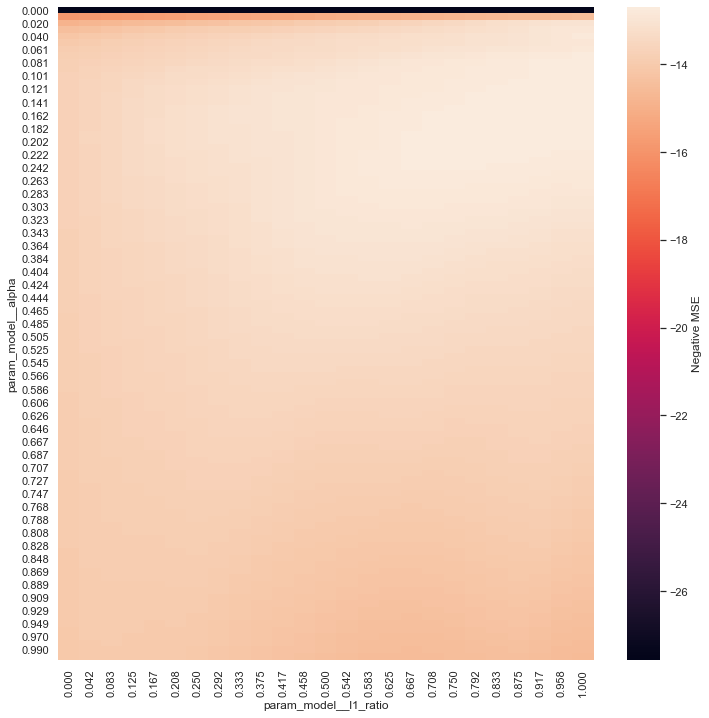

In [8]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')

plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt, cbar_kws={'label': 'Negative MSE'})

# Round ticks
ax.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_yticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])
ax.yaxis.set_tick_params()

The best performing hyper parameters across the cross validation folds turned out to be:

In [9]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

alpha = 0.182, l1-ratio: 0.917


Now the elastic net does not simplify to a lasso as it was the case without the external data - it does though still have a very large $\ell_1$-ratio. The regularizer is also much strong compared to part 1 in the case without the external data.

Using the above hyperparameters and the full training set the final elastic model is tried on the testing set and the $R^2$ is calculated:

In [10]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.5711997189374767


As it can be seen we get a score of $R^2 \approx 0.57$. This is a bit lower than in part 1 even though more variables are chosen. This is a result of the way machine learning models are trained with cross-validation. With a dataset of this size, it can turn out to be more "unlucky". As it can be seen from the tougher regularization the model has been more "unsure" during training. Let's also look at the MSE.

In [11]:
y_pred = elastic_net_cv.predict(X_test)
print('Train mse: ', round(mean_squared_error(y_train, y_pred = elastic_net_cv.predict(X_train)),4))
print('Test mse: ', round(mean_squared_error(y_test, y_pred),4))

Train mse:  9.5916
Test mse:  21.7434


This tells the same story of a slightly poorer performing model by introducing the geographic and meteorological variables - interestingly it must have confused the model. Again we will just touch upon the size of the test set that is quite small; by using the elastic net the goal is the reduce the variance of the prediction by introducing bias. This weighting has turned off *unlucky* in this case but on a different test set, it could have been better.

### Part 1.1 Coefficients Analysis

Let's see how the coefficients now looks. The same function is utilized to plot them.

In [12]:
def plot_coef(model, df):
    # get the column transformer object from the pipe object:
    ColumnTransformer = model.get_params()['estimator__steps'][0][1]

    # exstract the numerical and categorical columns
    numerical_features = ColumnTransformer.transformers[0][2]
    categorical_features = ColumnTransformer.transformers[1][2]

    # One hot encode the the names if there is categorical columns
    if categorical_columns:
        one_hot_names = [value.replace(" ", "_") for column in categorical_columns for value in df[column].value_counts().index]
    else:
        one_hot_names = []

    names = numerical_columns + one_hot_names

    coef_df = pd.DataFrame({
        'variable' : names,
        'coefficient' : model.best_estimator_.steps[-1][1].coef_,
        'feature' : np.concatenate((
            np.repeat('numeric_feature', len(numerical_columns)),
            np.repeat('categorical_feature', len(one_hot_names))
        ))
    })

    # Define figure, axes, and plot
    color_dict = {'numeric_feature': 'tab:blue', 'categorical_feature': 'tab:red'}

    # Manuelly adding legends...
    from matplotlib.lines import Line2D
    if len(coef_df['feature'].value_counts()) == 2:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6),
                        Line2D([0], [0], color='tab:red', lw=6)]
    else:
        custom_lines = [Line2D([0], [0], color='tab:blue', lw=6)]


    fig, ax = plt.subplots(figsize=(20, 10))
    coef_df.plot(
        x = 'variable', y = 'coefficient', kind = 'bar',
        ax = ax, color = [color_dict[x] for x in coef_df.feature],
        legend = False
    )


    plt.title('Coefficients of Features',fontsize=20)
    ax.set_ylabel('Coefficients',fontsize=12)
    ax.set_xlabel(None)
    ax.legend(custom_lines, ['Numerical Feature', 'Categorical Feature'])
    plt.show()

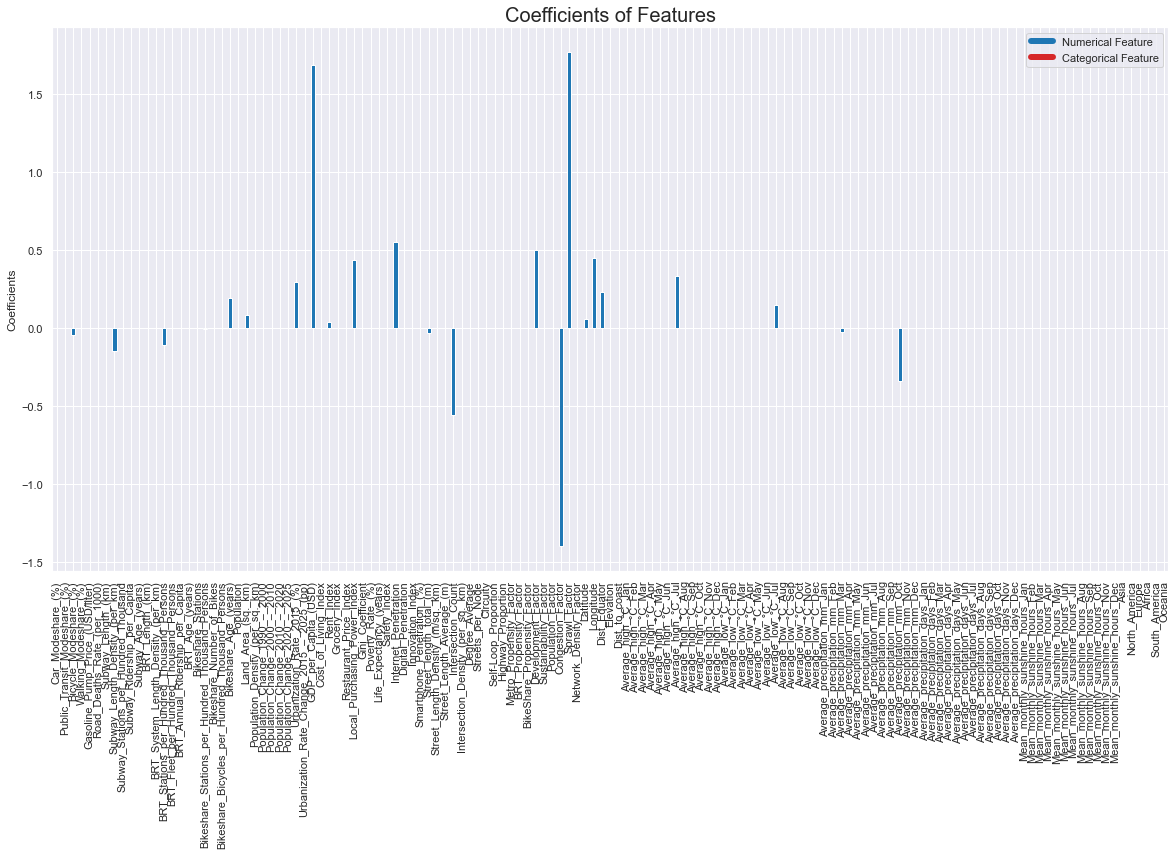

In [13]:
plot_coef(elastic_net_cv, X_train)

The model clearly has some of the same patterns from the version without external data for the original data. It does look most similar to the version where the test set is the continental split which probably is due to the more comparable regularization. 

Looking at the new data most of the variables get regularized out. It does though look like getting further the equator leads to a larger $CO_2$ emission as with Longitude. The longer away from the equator the colder it tends to get thus there is an extra need for heating which might cause larger emissions why it is not surprising to see a positive coefficient for the distance to the equator. To interpret on the longitude, cities north of the equator have higher emissions than cities south of the equator. This could make sense as most of the world's developed cities are north of the equator.

Average high-temperature July also has a positive coefficient.  This is much harder to interpret. As the variable is very correlated with the other high-temperature month in the summer period it might just be a measure for places with warm summers to have high emissions as well. Perhaps because of the use of air-conditioning.

There is also one negative weight with external data, namely the `Average precipitation in October`. Again this variable is highly correlated with variables describing precipitation in the other fall months, but why exactly the model thinks this affects lower CO2 emissions is hard to guess.

## Part 2: Prediction Challenge 2
Now we will consider the second challenge using the external data where the training/test split is made on a continent level.

Here we can't include Continent as the variables North and South America only exists in the testing set.

In [14]:
X_test = X[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')] 
y_test = y[(X['Continent'] == 'North America') | (X['Continent'] == 'South America')]

X_train = X[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')] 
y_train = y[(X['Continent'] != 'North America') & (X['Continent'] != 'South America')]

In [15]:
colum_names = X_train.columns

no_info_column = ['City', 'cityID', 'clusterID', 'Country', 'Typology', 'Continent']

columns_with_nan = df.columns[df.isnull().any()].tolist()
remove_columns = no_info_column + columns_with_nan

categorical_columns = []
numerical_columns = [ column for column in colum_names if column not in remove_columns+categorical_columns ]

Below are the different combinations of hyperparameters plotted in a heatmap with a color corresponding to the mean squared error across all cross-validation folds:

In [16]:
elastic_net_model = linear_model.ElasticNet(fit_intercept = True)

parameters = {
    'model__alpha': np.linspace(0, 1, 100),
    'model__l1_ratio': np.linspace(0, 1, 25)
}

elastic_net_pibe = getPipe(
    model = elastic_net_model,
    numerical_columns = numerical_columns,
    categorical_columns = categorical_columns
)
elastic_net_cv = cv(elastic_net_pibe, parameters, X_train, y_train, cf = 5)


Fitting 5 folds for each of 2500 candidates, totalling 12500 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1383s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 276

The set performing best on average on the validatons set are shown below:

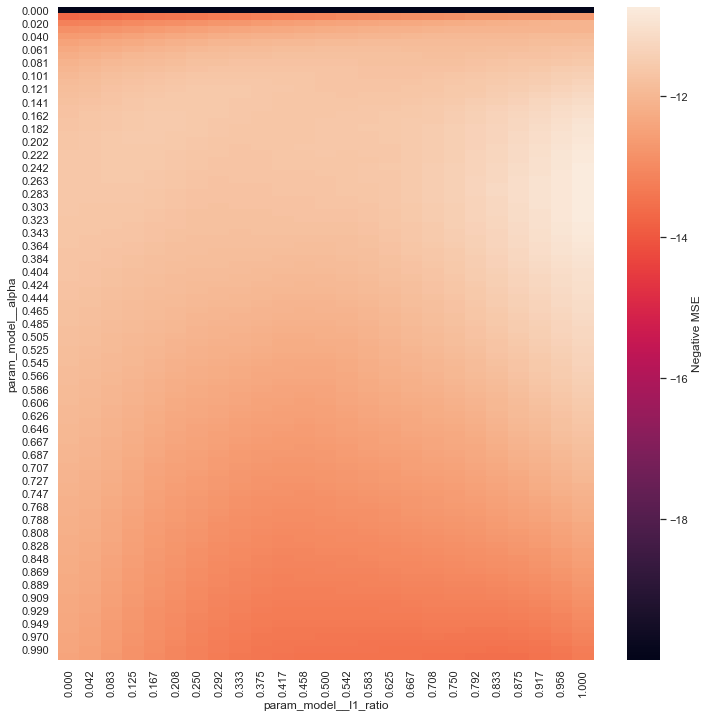

In [17]:
pvt = pd.pivot_table(pd.DataFrame(elastic_net_cv.cv_results_),
    values='mean_test_score', index='param_model__alpha', columns='param_model__l1_ratio')

plt.figure(figsize = (12,12))
ax = sns.heatmap(pvt, cbar_kws={'label': 'Negative MSE'})

# Round ticks
ax.set_xticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_xticklabels()])
ax.xaxis.set_tick_params(rotation=90)
ax.set_yticklabels(['{:.3f}'.format(float(t.get_text())) for t in ax.get_yticklabels()])
ax.yaxis.set_tick_params()

In [18]:
best_idx = elastic_net_cv.cv_results_['mean_test_score'].argmax()
alpha = elastic_net_cv.cv_results_['param_model__alpha'].data[best_idx]
l1_ratio = elastic_net_cv.cv_results_['param_model__l1_ratio'].data[best_idx]

print(f' alpha = {round(alpha, 3)}, l1-ratio: {round(l1_ratio,3)}')

alpha = 0.283, l1-ratio: 1.0


This model is very similar to the one found in the modelling without external data- the only difference is that a slightly harder regualization is used. Let's look at how it perform bsaed on $R^2$:

In [19]:
y_pred = elastic_net_cv.predict(X_test)
print('R2: ', r2_score(y_test, y_pred))

R2:  0.5942356599377576


Recall that 0.57 was obtained without the external data - now we get close to 0.6 which is a bit higher. Could it be that the external data helps? Let's look at the MSE:

In [20]:
print('Train mse: ', round(mean_squared_error(y_train, elastic_net_cv.predict(X_train)),4))
print('Test mse: ', round(mean_squared_error(y_test, y_pred),4))

Train mse:  8.2395
Test mse:  24.6874


Also here a slightly better performance is obtained in both the training and test case. The ratio between them is also very slightly better than before meaning that we generalize very slightly better. The hope was definitely that a greater improvement would have been detected but the chosen data did not seem to do a really big trick, sadly. 

### Part 2.2 Coefficients Analysis

Now let's see the coefficients from this model.

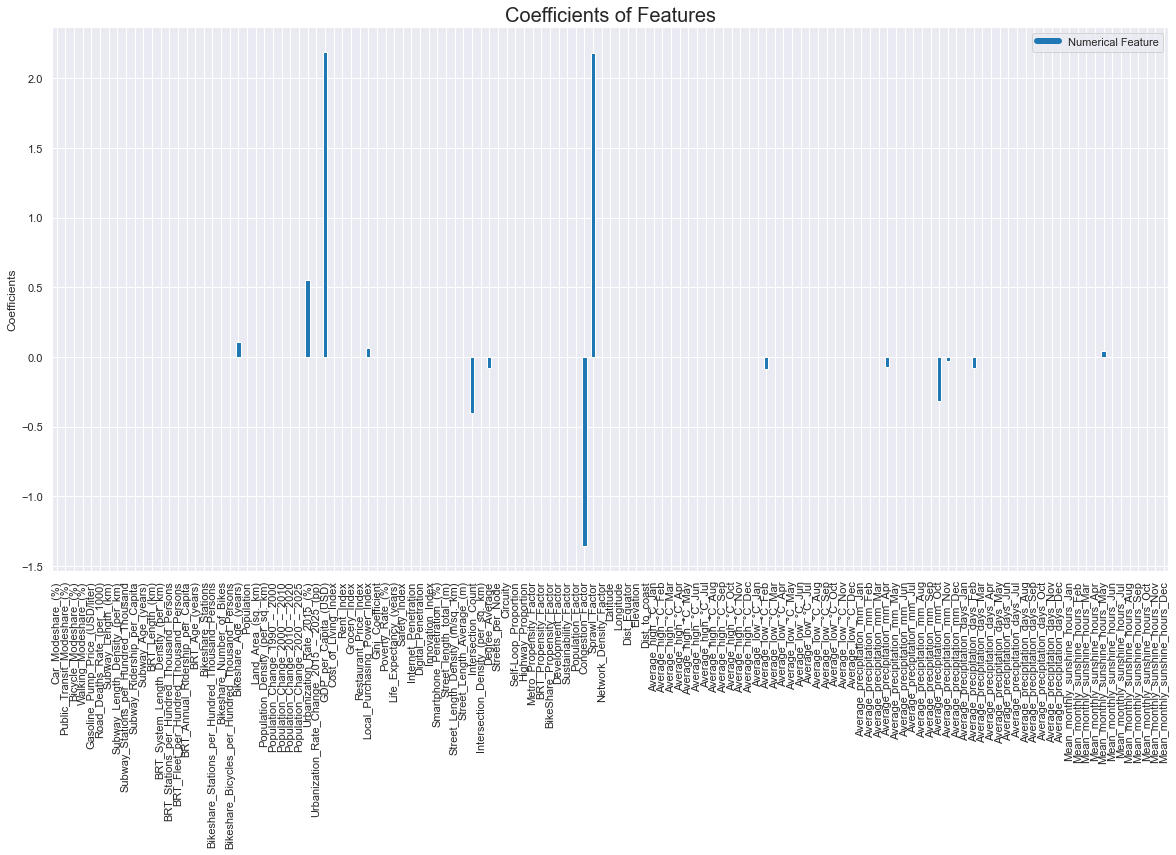

In [21]:
plot_coef(elastic_net_cv, X_train)

Again, the coefficients for the original data is very comparable to the ones from `3_Modelling_part1`. Interestingly the model was now chosen contains some different climate variables compared to the previous training/test split. The coefficients are though very small which is another clear indication that the inclusion of these really did not help the performance of the models. The negative coefficient for precipitation in October is again seen which still hard to interpret. Now lower temperatures in February lead to higher $CO_2$ emission which is not surprising. It is though interesting to see this variable picked instead of the distance to the equator which was chosen in part 1.